# 8-11. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

## 라이브러리 준비

In [ ]:
import konlpy
import gensim
from gensim import models

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
# plt.style.use('seaborn')
import seaborn as sns
sns.set(font_scale=2.5)

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences


import os
import re

---

## 1. 데이터 준비와 확인

In [ ]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
# 훈련 및 테스트 데이터의 리뷰 개수 확인
print('훈련 데이터 형태 :', train_data.shape)
print('테스트 데이터 형태 :', test_data.shape)

훈련 데이터 형태 : (150000, 3)
테스트 데이터 형태 : (50000, 3)


In [ ]:
print(train_data.columns)

Index(['id', 'document', 'label'], dtype='object')


---

## 2. 데이터로더 구성
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

1) 데이터의 중복 제거

train_data의 데이터 중복 유무 확인

In [ ]:
# 중복하지 않은 데이터의 개수
train_data[['document', 'label']].nunique()

document    146182
label            2
dtype: int64

In [ ]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

15000-146182 만큼의 중복 데이터가 있다는 것
중복 sample을 제거합니다.

In [ ]:
# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

In [ ]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


<AxesSubplot:>

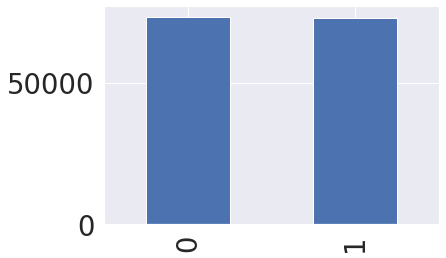

In [ ]:
# 긍정, 부정 분포 그리기
train_data['label'].value_counts().plot(kind = 'bar')

리뷰 중에 Null인 리뷰가 있는지?

In [ ]:
print(train_data.isnull().values.any())

True


In [ ]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거

다시한번 확인

In [ ]:
print(train_data.isnull().values.any())

False


Null값이 제거됨

이제 전처리를 수행해보자

In [ ]:
# 정규 표현식을 이용하여 한글, 숫자, 공백을 제외하고 모두 제거 
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9 ]", "")

train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


공백은 유지되면서 마침표 등의 특수문자는 제거되었다. 그렇다면 한글, 숫자, 공백이 아닌 다른 값으로 채워져 있던 리뷰들은 Null이 되었을 것이다.

In [ ]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)

# 다시 한 번 Null 값이 존재하는지 확인
print(train_data.isnull().sum())

id            0
document    685
label         0
dtype: int64


새로 생긴 Null을 제거하자

In [ ]:
# NaN은 아무런 의미가 없는 데이터 이므로 제거
train_data = train_data.dropna(how = 'any')

print('전처리 후 학습용 데이터 개수 :', len(train_data))

전처리 후 학습용 데이터 개수 : 145497


In [ ]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


전처리 후 근소하게 sample 수가 줄었음을 확인 할 수 있다

2) 토큰화, 불용어 제거, word to index

데이터 정제를 위해 LMS에서 제공한 코드를 사용했다. 이전 NLP와 같이 유의미한 부분을 얻기 위해 전처리 후 토큰화를 진행한다

In [ ]:
from konlpy.tag import Mecab

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]                  ## 이부분 필요 ★
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [ ]:
print("훈련 데이터 개수: {},  테스트 데이터 개수: {}".format(len(X_train), len(X_test)))

훈련 데이터 개수: 143797,  테스트 데이터 개수: 48389


In [ ]:
# key = index, value = word로 변경
index_to_word = {index:word for word, index in word_to_index.items()}

3) encoding / decoding

In [ ]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

---

## 3. 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences를 활용한 패딩 추가

1) 데이터셋 내 문장 길이 분포

In [ ]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  14.06614425608525
문장길이 최대 :  84
문장길이 표준편차 :  11.552819864987178


2) 적절한 최대 문장 길이 지정

<AxesSubplot:ylabel='Density'>

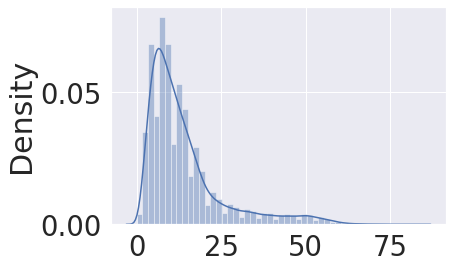

In [ ]:
# 문장 길이 분포 시각화
sns.distplot(num_tokens)

In [ ]:
# 최대 길이를 (평균 + 3*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 3 * np.std(num_tokens)
maxlen = int(max_tokens)

print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens) * 100))

pad_sequences maxlen :  48
전체 문장의 97.08875776591427%가 maxlen 설정값 이내에 포함됩니다. 


3) keras.preprocessing.sequence.pad_sequences를 활용한 패딩 추가

이때 패딩은 pre 포지션에 위치해야 유리하다. 마지막 입력이 최종 state에 가장 큰 영향을 미치기 때문이다.

In [ ]:
# 문장의 길이가 maxlen 보다 짧은 문장에 <PAD>를 앞부분에 추가
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print('shape of X_train : ', X_train.shape)
print('shape of X_test : ', X_test.shape)

shape of X_train :  (143797, 48)
shape of X_test :  (48389, 48)


---

## 4. 모델 구성 및 validation set 구성
- 모델은 3가지 이상 다양하게 구성하여 실험해보세요.

train set / validation set 구성

Train dataset과 Validation dataset은 특별한 이유가 없는 이상 8:2로 분리하기로 한다

In [ ]:
# train data set에서 80:20의 비율로 train과 validation으로 분리, RNN에서는 순서가 중요하므로 shuffle은 진행하지 않도록 한다.
# train set
partial_X_train = X_train[:int(X_train.shape[0]*0.8)]
partial_y_train = y_train[:int(y_train.shape[0]*0.8)]

# validation set
X_val = X_train[int(X_train.shape[0]*0.8):]
y_val = y_train[int(y_train.shape[0]*0.8):]

print('partial_x_train :', partial_X_train.shape)
print('partial_y_train :', partial_y_train.shape)
print('x_valid :', X_val.shape)
print('y_valid :', y_val.shape)

partial_x_train : (115037, 48)
partial_y_train : (115037,)
x_valid : (28760, 48)
y_valid : (28760,)


1) RNN

In [ ]:
vocab_size = 10000
word_vector_dim = 200

In [ ]:
# LSTM
lstm = keras.Sequential()
lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm.add(keras.layers.LSTM(8))
lstm.add(keras.layers.Dense(8, activation='relu'))
lstm.add(keras.layers.Dense(1, activation='sigmoid'))

lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 6688      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


2) 1-D Convolution Neural Network(1-D CNN)

In [ ]:
# 1-D CNN
cnn = keras.Sequential()
cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) 
cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn.add(keras.layers.MaxPooling1D(5))
cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn.add(keras.layers.GlobalMaxPooling1D())
cnn.add(keras.layers.Dense(16, activation='relu'))
cnn.add(keras.layers.Dense(1, activation='sigmoid'))

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          22416     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

3) GlobalMaxPooling1D 레이어

In [ ]:
# one GlobalAveragePooling layer
simple = keras.Sequential()
simple.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
simple.add(keras.layers.GlobalAveragePooling1D())
simple.add(keras.layers.Dense(8, activation='relu'))
simple.add(keras.layers.Dense(1, activation='sigmoid'))

simple.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


---

## 5. 모델 훈련 개시

In [ ]:
# epochs = 10 -> 고정하지 않기 (주석처리)

1) RNN

In [ ]:
lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_lstm = lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
225/225 [==============================] - 5s 9ms/step - loss: 0.4904 - accuracy: 0.7799 - val_loss: 0.3699 - val_accuracy: 0.8431
Epoch 2/10
225/225 [==============================] - 2s 7ms/step - loss: 0.3309 - accuracy: 0.8613 - val_loss: 0.3469 - val_accuracy: 0.8492
Epoch 3/10
225/225 [==============================] - 2s 7ms/step - loss: 0.2937 - accuracy: 0.8774 - val_loss: 0.3474 - val_accuracy: 0.8521
Epoch 4/10
225/225 [==============================] - 2s 7ms/step - loss: 0.2688 - accuracy: 0.8879 - val_loss: 0.3516 - val_accuracy: 0.8490
Epoch 5/10
225/225 [==============================] - 2s 7ms/step - loss: 0.2475 - accuracy: 0.8975 - val_loss: 0.3646 - val_accuracy: 0.8468
Epoch 6/10
225/225 [==============================] - 2s 7ms/step - loss: 0.2288 - accuracy: 0.9063 - val_loss: 0.3851 - val_accuracy: 0.8453
Epoch 7/10
225/225 [==============================] - 2s 7ms/step - loss: 0.2114 - accuracy: 0.9139 - val_loss: 0.4031 - val_accuracy: 0.8434
Epoch 

2) 1-D Convolution Neural Network(1-D CNN)

In [ ]:
cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history_cnn = cnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=5,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
225/225 [==============================] - 4s 8ms/step - loss: 0.5089 - accuracy: 0.7383 - val_loss: 0.4200 - val_accuracy: 0.8018
Epoch 2/5
225/225 [==============================] - 1s 7ms/step - loss: 0.3810 - accuracy: 0.8236 - val_loss: 0.4094 - val_accuracy: 0.8071
Epoch 3/5
225/225 [==============================] - 1s 7ms/step - loss: 0.3271 - accuracy: 0.8535 - val_loss: 0.4187 - val_accuracy: 0.8080
Epoch 4/5
225/225 [==============================] - 2s 7ms/step - loss: 0.2631 - accuracy: 0.8873 - val_loss: 0.4653 - val_accuracy: 0.7981
Epoch 5/5
225/225 [==============================] - 2s 7ms/step - loss: 0.2015 - accuracy: 0.9151 - val_loss: 0.5173 - val_accuracy: 0.7965


3) GlobalMaxPooling1D 레이어

In [ ]:
simple.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_simple = simple.fit(partial_X_train,
                    partial_y_train,
                    epochs=5,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
225/225 [==============================] - 2s 5ms/step - loss: 0.5458 - accuracy: 0.7470 - val_loss: 0.4053 - val_accuracy: 0.8273
Epoch 2/5
225/225 [==============================] - 1s 5ms/step - loss: 0.3695 - accuracy: 0.8431 - val_loss: 0.3681 - val_accuracy: 0.8401
Epoch 3/5
225/225 [==============================] - 1s 5ms/step - loss: 0.3399 - accuracy: 0.8561 - val_loss: 0.3674 - val_accuracy: 0.8411
Epoch 4/5
225/225 [==============================] - 1s 5ms/step - loss: 0.3266 - accuracy: 0.8623 - val_loss: 0.3665 - val_accuracy: 0.8416
Epoch 5/5
225/225 [==============================] - 1s 5ms/step - loss: 0.3183 - accuracy: 0.8654 - val_loss: 0.3667 - val_accuracy: 0.8432


---

## 6. Loss, Accuracy 그래프 시각화

1) RNN

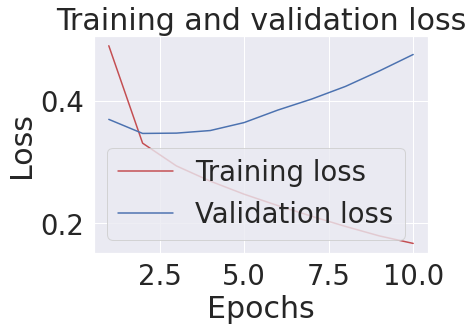

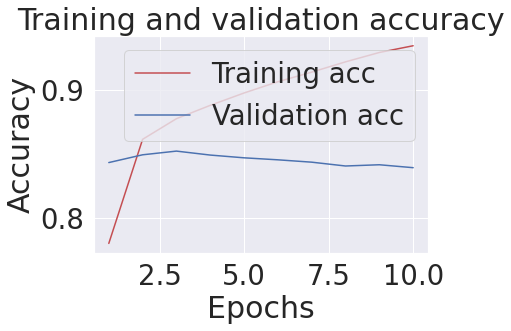

In [ ]:
history_dict = history_lstm.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 그림을 초기화
plt.clf()

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

2) 1-D Convolution Neural Network(1-D CNN)

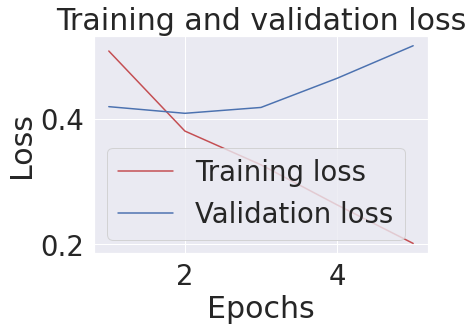

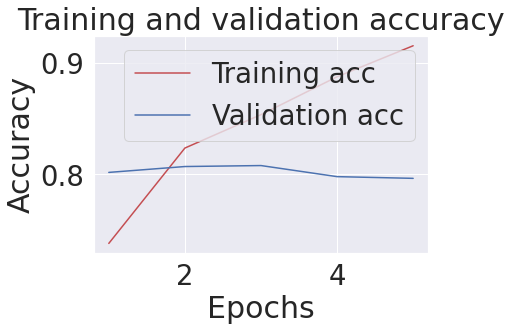

In [ ]:
history_dict = history_cnn.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()


plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

3) GlobalMaxPooling1D 레이어

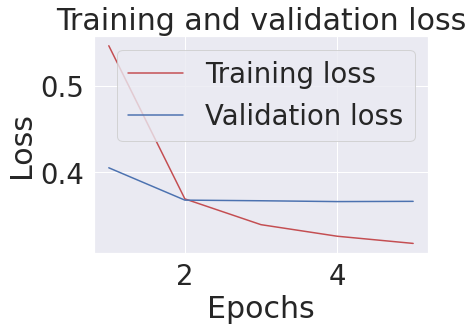

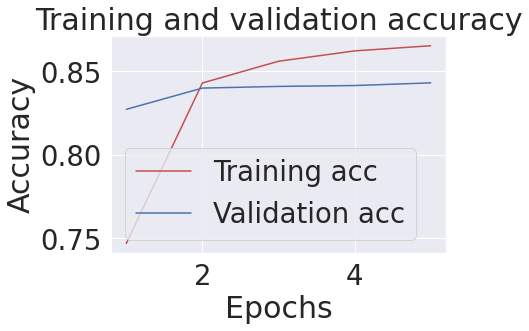

In [ ]:
history_dict = history_simple.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

모델 평가

In [ ]:
# LSTM
print("LSTM")
results_lstm = lstm.evaluate(X_test, y_test, verbose=2)
print(results_lstm)
print("-------------------------------------------------------------------------")

# 1-D CNN
print("1-D CNN")
results_cnn = cnn.evaluate(X_test, y_test, verbose=2)
print(results_cnn)
print("-------------------------------------------------------------------------")

# GlobalAveragePooling1D
print("GlobalAveragePooling1D layer")
results_simple = simple.evaluate(X_test, y_test, verbose=2)
print(results_simple)

LSTM
1513/1513 - 3s - loss: 0.4916 - accuracy: 0.8346
[0.49163755774497986, 0.834590494632721]
-------------------------------------------------------------------------
1-D CNN
1513/1513 - 3s - loss: 0.5260 - accuracy: 0.7891
[0.5260390639305115, 0.7891256213188171]
-------------------------------------------------------------------------
GlobalAveragePooling1D layer
1513/1513 - 2s - loss: 0.3740 - accuracy: 0.8392
[0.373958557844162, 0.839240312576294]


~높은데..?~

---

## 7. 학습된 Embedding 레이어 분석

In [ ]:
# 단어의 특성을 저차원 벡터값으로 표현할 수 있는 워드 임베딩(word embedding) 기법
embedding_lstm = lstm.layers[0]
weights_lstm = embedding_lstm.get_weights()[0]
print('LSTM :',weights_lstm.shape)    # shape: (vocab_size, embedding_dim)

embedding_cnn = cnn.layers[0]
weights_cnn = embedding_cnn.get_weights()[0]
print('CNN :',weights_cnn.shape)    # shape: (vocab_size, embedding_dim)

embedding_simple = simple.layers[0]
weights_simple = embedding_simple.get_weights()[0]
print('GlobalMaxPooling1D :',weights_simple.shape)    # shape: (vocab_size, embedding_dim)

LSTM : (10000, 200)
CNN : (10000, 200)
GlobalMaxPooling1D : (10000, 200)


In [ ]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path_lstm = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_lstm.txt'
f = open(word2vec_file_path_lstm, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))# 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다.
vectors = lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()


word2vec_file_path_cnn = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_cnn.txt'
f = open(word2vec_file_path_cnn, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))
vectors = cnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()


word2vec_file_path_simple = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_simple.txt'
f = open(word2vec_file_path_simple, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))
vectors = simple.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()


In [ ]:
# 임베딩 파라미터를 읽어서 word vector로 활용
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors_lstm = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_lstm, binary=False)

word_vectors_cnn = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_cnn, binary=False)

word_vectors_simple = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_simple, binary=False)

In [ ]:
word_vectors_lstm.similar_by_word("조연")

[('23', 0.727982759475708),
 ('제작사', 0.6526796817779541),
 ('막말', 0.6520798206329346),
 ('깔', 0.6464850306510925),
 ('셧', 0.6455925703048706),
 ('보복', 0.6454275250434875),
 ('비리', 0.6428426504135132),
 ('갑옷', 0.6365862488746643),
 ('천하', 0.6285982131958008),
 ('더라면', 0.6285638213157654)]

In [ ]:
word_vectors_cnn.similar_by_word("조연")

[('65', 0.4495278298854828),
 ('찌질', 0.42648178339004517),
 ('저렇게', 0.4249178171157837),
 ('드림', 0.4091104567050934),
 ('둘', 0.40829750895500183),
 ('설교', 0.40592601895332336),
 ('블루', 0.40511199831962585),
 ('데이빗', 0.39807236194610596),
 ('유준상', 0.3980584740638733),
 ('멜로', 0.39542683959007263)]

In [ ]:
word_vectors_simple.similar_by_word("조연")

[('너무', 0.3967977464199066),
 ('만드', 0.38573694229125977),
 ('대사', 0.3805394470691681),
 ('배우', 0.37983494997024536),
 ('장면', 0.3723943531513214),
 ('의해', 0.3620816469192505),
 ('캐릭터', 0.35583916306495667),
 ('과거', 0.3536623418331146),
 ('메시지', 0.3520388901233673),
 ('첫', 0.35173097252845764)]

세가지 모델 다 높은 accuracy에 비해서 제시된 단어에 대해 터무니없는 단어를 유사하다고 계산한다

---

## 8. 한국어 Word2Vec 임베딩을 활용하여 성능 개선
- 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
- 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요.

word2vec kor를 이용하여 성능개선을 이루어보자

In [ ]:
# 한국어 Word2Vec 임베딩 활용한 성능 개선

# 예시 코드
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = os.getenv('HOME') + '/aiffel/sentiment_classification/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv["끝"]

# word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
# vector = word_vectors.wv[‘끝’]

In [ ]:
word_vectors.wv.similar_by_word("조연")

[('단역', 0.8401904106140137),
 ('배역', 0.7536360621452332),
 ('상대역', 0.7231706380844116),
 ('여주인공', 0.7189265489578247),
 ('주연', 0.6905761957168579),
 ('악역', 0.6875844597816467),
 ('아역', 0.684779167175293),
 ('조감독', 0.6827622652053833),
 ('스턴트맨', 0.6694765686988831),
 ('데뷔작', 0.657950758934021)]

이전 유사단어와는 확연히 차이가 날 정도로 정말 관련성 높은 단어들이 제시되었다!

In [ ]:
vocab_size = vocab_size    ## 어휘사전의 크기
word_vector_dim = word_vectors.wv.vectors.shape[1]    ## 워드 벡터의 차원 수

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)
print("embedding_matrix.shape :", embedding_matrix.shape)

embedding_matrix.shape : (10000, 100)


In [ ]:
# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [ ]:
from tensorflow.keras.initializers import Constant

In [ ]:

# LSTM
new_lstm = keras.Sequential()
new_lstm.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
new_lstm.add(keras.layers.LSTM(128))
new_lstm.add(keras.layers.Dense(128, activation='relu'))
new_lstm.add(keras.layers.Dense(1, activation='sigmoid'))

new_lstm.summary()

# 1-D CNN
new_cnn = keras.Sequential()
new_cnn.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
new_cnn.add(keras.layers.Dropout(0.5))
new_cnn.add(keras.layers.Conv1D(512, 7, activation='relu'))
new_cnn.add(keras.layers.MaxPooling1D(5))
new_cnn.add(keras.layers.Conv1D(512, 7, activation='relu'))
new_cnn.add(keras.layers.GlobalMaxPooling1D())
new_cnn.add(keras.layers.Dense(256, activation='relu'))
new_cnn.add(keras.layers.Dense(1, activation='sigmoid'))

new_cnn.summary()

# one GlobalAveragePooling1D layer
new_simple = keras.Sequential()
new_simple.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))

new_simple.add(keras.layers.GlobalAveragePooling1D())
new_simple.add(keras.layers.Dense(128, activation='relu'))
new_simple.add(keras.layers.Dropout(0.1))
new_simple.add(keras.layers.Dense(1, activation='sigmoid'))

new_simple.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 48, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 1,133,889
Trainable params: 1,133,889
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 48, 100)           1000000   
______________________

In [ ]:
new_lstm.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

history_lstm = new_lstm.fit(partial_X_train,
                        partial_y_train,
                        epochs=5,
                        batch_size=256,
                        validation_data=(X_val, y_val),
                        verbose=1)


new_cnn.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])


history_new_cnn = new_cnn.fit(partial_X_train,
                              partial_y_train,
                              epochs=5,
                              batch_size=256,
                              validation_data=(X_val, y_val),
                              verbose=1)
                    

new_simple.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_new_simple = new_simple.fit(partial_X_train,
                    partial_y_train,
                    epochs=5,
                    batch_size=256,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
450/450 [==============================] - 5s 9ms/step - loss: 0.4454 - accuracy: 0.7859 - val_loss: 0.3764 - val_accuracy: 0.8294
Epoch 2/5
450/450 [==============================] - 4s 8ms/step - loss: 0.3297 - accuracy: 0.8553 - val_loss: 0.3318 - val_accuracy: 0.8565
Epoch 3/5
450/450 [==============================] - 4s 8ms/step - loss: 0.2841 - accuracy: 0.8792 - val_loss: 0.3306 - val_accuracy: 0.8569
Epoch 4/5
450/450 [==============================] - 4s 8ms/step - loss: 0.2502 - accuracy: 0.8952 - val_loss: 0.3311 - val_accuracy: 0.8616
Epoch 5/5
450/450 [==============================] - 4s 8ms/step - loss: 0.2199 - accuracy: 0.9095 - val_loss: 0.3402 - val_accuracy: 0.8595
Epoch 1/5
450/450 [==============================] - 9s 19ms/step - loss: 0.6621 - accuracy: 0.6368 - val_loss: 0.5326 - val_accuracy: 0.7347
Epoch 2/5
450/450 [==============================] - 8s 18ms/step - loss: 0.5361 - accuracy: 0.7238 - val_loss: 0.4756 - val_accuracy: 0.7702
Epoch 3/5
4

In [ ]:
# LSTM
results_new_lstm = new_lstm.evaluate(X_test, y_test, verbose=2)
print(results_new_lstm)

# 1-D CNN
results_new_cnn = new_cnn.evaluate(X_test, y_test, verbose=2)
print(results_new_cnn)

# one GlobalAveragePooling1D layer
results_new_simple = new_simple.evaluate(X_test, y_test, verbose=2)
print(results_new_simple)

1513/1513 - 3s - loss: 0.3509 - accuracy: 0.8543
[0.35094353556632996, 0.8543263673782349]
1513/1513 - 3s - loss: 0.4334 - accuracy: 0.7917
[0.4333619177341461, 0.7916675209999084]
1513/1513 - 2s - loss: 0.3703 - accuracy: 0.8361
[0.370254248380661, 0.8360784649848938]


accuracy에 대해서는 LSTM만 루브릭조건을 충족하는 85.4%다. 해당 모델을 이용하여 진짜 예측을 해보자!

In [ ]:
def wordlist_to_indexlist(wordlist):
    return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = tokenizer.morphs(new_sentence) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = [wordlist_to_indexlist(new_sentence)] #tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = maxlen) # 패딩
    score = float(new_lstm.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [ ]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

92.12% 확률로 긍정 리뷰입니다.



In [ ]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

98.81% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('내가 만들어도 이거보다 잘 만들듯')

98.68% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('이딴영화 투자한 투자자가 불쌍하다ㅋㅋ')

99.59% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('이 영화 보면서 진짜 펑펑 울었어요ㅠㅠ')

99.64% 확률로 긍정 리뷰입니다.



상당히 well-made인 것 같다. 이상으로 프로젝트를 마친다.

---

## 9. 마치며

- 다행히 이전 프로젝트처럼 컴퓨팅리소스나 시간이 부족하지 않아서 좀더 여유롭게 공부 할 수 있었다.
- 사실 accuracy가 0.85에 근사하게 나왔을 때, word2vec 개선을 통해 유의미하게 높여서 여유롭게 목표치를 충족 할 수 있을거라 생각했는데, 의외로 미미한 증가가 있어서 다소 실망했지만 마지막에 실제 센텐스를 예측하니 실질적으로 유의미한 변화를 이룬 것을 확인한 점이 이번 프로젝트의 가장 즐거운 부분이었다.
- 그럼에도 불구하고 부족한 accuracy 목표치는 파라메터를 수정하는 등의 방식으로 다행히 도달 할 수 있었다.
- 그동안 NLP 분야에 대해 다소 흥미가 없었는데 이번 프로젝트를 통해 재미를 발견 할 수 있어서 좋았다.
- 회고에 항상 쓰는 말이지만 앞으로도 열심히하자!